# Восстановление золота из руды

**Описание процесса**

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

**Цель:**

Создать модель для предсказания коэффициента восстановления золота из золотосодержащей руды. Метрика - sMAPE

**Задачи:**

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.


**Описание данных:**
- Rougher feed — исходное сырье
- Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
- Xanthate — ксантогенат (промотер, или активатор флотации);
- Sulphate — сульфат (на данном производстве сульфид натрия);
- Depressant — депрессант (силикат натрия).
- Rougher process (англ. «грубый процесс») — флотация
- Rougher tails — отвальные хвосты
- Float banks — флотационная установка
- Cleaner process — очистка
- Rougher Au — черновой концентрат золота
- Final Au — финальный концентрат золота

**Параметры этапов**
- air amount — объём воздуха
- fluid levels — уровень жидкости
- feed size — размер гранул сырья
- feed rate — скорость подачи

**Наименование признаков**

**[этап].[тип_параметра].[название_параметра]**

- Пример: rougher.input.feed_ag

**Возможные значения для блока [этап]:**
- rougher — флотация
- primary_cleaner — первичная очистка
- secondary_cleaner — вторичная очистка
- final — финальные характеристики

**Возможные значения для блока [тип_параметра]:**
- input — параметры сырья
- output — параметры продукта
- state — параметры, характеризующие текущее состояние этапа
- calculation — расчётные характеристики

# Импорт библиотек

In [211]:
#Pandas
import pandas as pd

# Seaborn
import seaborn as sns

#np
import numpy as np

#plt
import matplotlib.pyplot as plt

#scipy
from scipy import stats as st

#Scikit-learn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn import svm
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.dummy import DummyRegressor

# Загрузка и осмотр данных

- Попробовал быстро осмотреть данные
- Не вышло, очень много всего

data_full = pd.read_csv('gold_recovery_full_new.csv')
data_train = pd.read_csv('gold_recovery_train_new.csv')
data_test = pd.read_csv('gold_recovery_test_new.csv')

In [212]:
data_train = pd.read_csv('gold_recovery_train_new.csv')
data_test = pd.read_csv('gold_recovery_test_new.csv')
data_full = pd.read_csv('gold_recovery_full_new.csv')

Размеры данных

In [213]:
print(data_full.shape)
print(data_train.shape)
print(data_test.shape)

(19439, 87)
(14149, 87)
(5290, 53)


Пропуски

In [214]:
print(data_full.isna().sum().sum())
print(data_train.isna().sum().sum())
print(data_test.isna().sum().sum())

4481
4100
90


Огромное количество столбцов, что в них?

<style>
    .bordered-cell {
        border: 3px solid black;
        padding: 10px;
    }
</style>

<div class="bordered-cell">

**Вывод**

- Просто взглянуть на данные и сходу всё понять не получится
- Нужно разбить данные полные (data_full) на несколько таблиц в зависимости от типа данных и отдельно анализировать

# Разбиваю данные для подробного осмотра


- Здесь очень много выводов названий столбцов
- Эта часть тетрадки исключительно, чтоб разобраться с какими данными я имею дело

In [215]:
columns_rougher_list = pd.Series(list(filter(lambda a: 'rougher' in a, data_full.columns)))
print(columns_rougher_list)

0         rougher.calculation.sulfate_to_au_concentrate
1     rougher.calculation.floatbank10_sulfate_to_au_...
2     rougher.calculation.floatbank11_sulfate_to_au_...
3                       rougher.calculation.au_pb_ratio
4                                 rougher.input.feed_ag
5                                 rougher.input.feed_pb
6                               rougher.input.feed_rate
7                               rougher.input.feed_size
8                                rougher.input.feed_sol
9                                 rougher.input.feed_au
10                    rougher.input.floatbank10_sulfate
11                   rougher.input.floatbank10_xanthate
12                    rougher.input.floatbank11_sulfate
13                   rougher.input.floatbank11_xanthate
14                        rougher.output.concentrate_ag
15                        rougher.output.concentrate_pb
16                       rougher.output.concentrate_sol
17                        rougher.output.concent

In [216]:
columns_primary_cleaner_list = pd.Series(list(filter(lambda a: 'primary_cleaner' in a, data_full.columns)))
print(columns_primary_cleaner_list)

0                primary_cleaner.input.sulfate
1             primary_cleaner.input.depressant
2              primary_cleaner.input.feed_size
3               primary_cleaner.input.xanthate
4        primary_cleaner.output.concentrate_ag
5        primary_cleaner.output.concentrate_pb
6       primary_cleaner.output.concentrate_sol
7        primary_cleaner.output.concentrate_au
8               primary_cleaner.output.tail_ag
9               primary_cleaner.output.tail_pb
10             primary_cleaner.output.tail_sol
11              primary_cleaner.output.tail_au
12      primary_cleaner.state.floatbank8_a_air
13    primary_cleaner.state.floatbank8_a_level
14      primary_cleaner.state.floatbank8_b_air
15    primary_cleaner.state.floatbank8_b_level
16      primary_cleaner.state.floatbank8_c_air
17    primary_cleaner.state.floatbank8_c_level
18      primary_cleaner.state.floatbank8_d_air
19    primary_cleaner.state.floatbank8_d_level
dtype: object


In [217]:
columns_secondary_cleaner_list = pd.Series(list(filter(lambda a: 'secondary_cleaner' in a, data_full.columns)))
print(columns_secondary_cleaner_list)

0               secondary_cleaner.output.tail_ag
1               secondary_cleaner.output.tail_pb
2              secondary_cleaner.output.tail_sol
3               secondary_cleaner.output.tail_au
4       secondary_cleaner.state.floatbank2_a_air
5     secondary_cleaner.state.floatbank2_a_level
6       secondary_cleaner.state.floatbank2_b_air
7     secondary_cleaner.state.floatbank2_b_level
8       secondary_cleaner.state.floatbank3_a_air
9     secondary_cleaner.state.floatbank3_a_level
10      secondary_cleaner.state.floatbank3_b_air
11    secondary_cleaner.state.floatbank3_b_level
12      secondary_cleaner.state.floatbank4_a_air
13    secondary_cleaner.state.floatbank4_a_level
14      secondary_cleaner.state.floatbank4_b_air
15    secondary_cleaner.state.floatbank4_b_level
16      secondary_cleaner.state.floatbank5_a_air
17    secondary_cleaner.state.floatbank5_a_level
18      secondary_cleaner.state.floatbank5_b_air
19    secondary_cleaner.state.floatbank5_b_level
20      secondary_cl

In [218]:
columns_final_list = pd.Series(list(filter(lambda a: 'final' in a, data_full.columns)))
print(columns_final_list)

0     final.output.concentrate_ag
1     final.output.concentrate_pb
2    final.output.concentrate_sol
3     final.output.concentrate_au
4           final.output.recovery
5            final.output.tail_ag
6            final.output.tail_pb
7           final.output.tail_sol
8            final.output.tail_au
dtype: object


Итого у нас 87 столбцов, из них 35 флотация, 20 первичная очистка, 22 вторичная очистка, 9 финальные характеристики и один столбец - время

Посмотрим на данные начальные и конечные

In [219]:
list_start_final_columns = ['rougher.input.feed_ag',
                            'rougher.input.feed_pb',
                            'rougher.input.feed_sol',
                            'rougher.input.feed_au',
                            'final.output.concentrate_ag',
                            'final.output.concentrate_pb',
                            'final.output.concentrate_sol',
                            'final.output.concentrate_au',
                            'final.output.recovery'
                           ]

In [220]:
display(data_full[list_start_final_columns].head(5))

,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery
0,6.100378,2.284912,36.808594,6.486150,6.055403,9.889648,5.507324,42.192020,70.541216
1,6.161113,2.266033,35.753385,6.478583,6.029369,9.968944,5.257781,42.701629,69.266198
2,6.116455,2.159622,35.971630,6.362222,6.055926,10.213995,5.383759,42.657501,68.116445
3,6.043309,2.037807,36.862241,6.118189,6.047977,9.977019,4.858634,42.689819,68.347543
4,6.060915,1.786875,34.347666,5.663707,6.148599,10.142511,4.939416,42.774141,66.927016


Стало чуть понятнее, попробую разобрать только связанные с золотом колонки

In [221]:
columns_au_list_all = pd.Series(list(filter(lambda a: 'au' in a, data_full.columns)))
print(columns_au_list_all)
print(list(columns_au_list_all[5:7]))

0                           final.output.concentrate_au
1                                  final.output.tail_au
2                 primary_cleaner.output.concentrate_au
3                        primary_cleaner.output.tail_au
4         rougher.calculation.sulfate_to_au_concentrate
5     rougher.calculation.floatbank10_sulfate_to_au_...
6     rougher.calculation.floatbank11_sulfate_to_au_...
7                       rougher.calculation.au_pb_ratio
8                                 rougher.input.feed_au
9                         rougher.output.concentrate_au
10                               rougher.output.tail_au
11                     secondary_cleaner.output.tail_au
dtype: object
['rougher.calculation.floatbank10_sulfate_to_au_feed', 'rougher.calculation.floatbank11_sulfate_to_au_feed']


In [222]:
columns_au_list_selected = pd.Series(['rougher.input.feed_au',
                                      'rougher.output.concentrate_au',
                                      'primary_cleaner.output.concentrate_au',
                                      'final.output.concentrate_au',
                                      'rougher.output.tail_au',
                                      'primary_cleaner.output.tail_au',
                                      'secondary_cleaner.output.tail_au',
                                      'final.output.tail_au',
                                      'final.output.recovery'
                                     ])

In [223]:
display(data_full[columns_au_list_selected].head(5))

,rougher.input.feed_au,rougher.output.concentrate_au,primary_cleaner.output.concentrate_au,final.output.concentrate_au,rougher.output.tail_au,primary_cleaner.output.tail_au,secondary_cleaner.output.tail_au,final.output.tail_au,final.output.recovery
0,6.486150,19.793808,34.174427,42.192020,1.170244,2.106679,2.606185,2.143149,70.541216
1,6.478583,20.050975,34.118526,42.701629,1.184827,2.353017,2.488248,2.224930,69.266198
2,6.362222,19.737170,33.969464,42.657501,1.162562,2.416800,2.458187,2.257889,68.116445
3,6.118189,19.320810,28.260743,42.689819,1.079755,2.262051,2.322062,2.146849,68.347543
4,5.663707,19.216101,33.044932,42.774141,1.012642,2.277073,2.330448,2.055292,66.927016


<style>
    .bordered-cell {
        border: 3px solid black;
        padding: 10px;
    }
</style>

<div class="bordered-cell">

**Вывод**:

Судя по всему в данных указана концентрация соединения или концентрация элемента в каком-то объеме, массе или еще в чем-то.

**F — доля золота в сырье/концентрате до флотации/очистки:**
- rougher.input.feed_au

**C — доля золота в концентрате после флотации/очистки:**
- rougher.output.concentrate_au
- primary_cleaner.output.concentrate_au
- final.output.concentrate_au

**T — доля золота в отвальных хвостах после флотации/очистки:**
- rougher.output.tail_au,
- primary_cleaner.output.tail_au,
- secondary_cleaner.output.tail_au,
- final.output.tail_au

# Подготовка данных

**ЗАДАЧА 1.2.**

Проверьте, что эффективность обогащения рассчитана правильно. Вычислите её на обучающей выборке для признака rougher.output.recovery. Найдите MAE между вашими расчётами и значением признака. Опишите выводы.

<style>
    .bordered-cell {
        border: 3px solid black;
        padding: 10px;
    }
</style>

<div class="bordered-cell">

**Формула для recovery:**

C*(F-T) / F*(C-T) * 100%,

- C (final) (final.output.concentrate_au) — доля золота в концентрате после флотации/очистки;
- F (raw) (rougher.input.feed_au) — доля золота в сырье/концентрате до флотации/очистки;
- T (tail) (final.output.tail_au) — доля золота в отвальных хвостах после флотации/очистки.

In [224]:
# Функция для подсчета эффективности обогащения
def recovery(arg):
    C=arg[0]
    F=arg[1]
    T=arg[2]
    result = (C*(F-T)) / (F*(C-T)) * 100
    return result

In [225]:
# Cчитаю эффективность для всей обучающей выборки в столбец ['my_au_recovery']
recovery_columns_list = ['rougher.output.concentrate_au', 'rougher.input.feed_au', 'rougher.output.tail_au']

data_train['my_au_recovery'] = data_train[recovery_columns_list].apply(recovery, axis=1)

display(data_train[['my_au_recovery','rougher.output.recovery']].head(3))

,my_au_recovery,rougher.output.recovery
0,87.107763,87.107763
1,86.843261,86.843261
2,86.842308,86.842308


Всё работает, считаю MAE

In [226]:
print('MAE =', mean_absolute_error(data_train['rougher.output.recovery'], data_train['my_au_recovery']))

MAE = 9.73512347450521e-15


**ЗАДАЧА 1.3.**

Проанализируйте признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?

In [227]:
# Параметры для этапа подачи сырья и флотации
columns_rougher_list_test = pd.Series(list(filter(lambda a: 'rougher' in a, data_test.columns)))

print('Список признаков которых нет в тестовых данных для этапа подачи сырья и флотации')
print(columns_rougher_list[~columns_rougher_list.isin(columns_rougher_list_test)].reset_index())
print('Не хватает', columns_rougher_list[~columns_rougher_list.isin(columns_rougher_list_test)].count(), 'признаков')
print('Всего признаков в полных данных', columns_rougher_list.count())

#print(columns_rougher_list_test)

Список признаков которых нет в тестовых данных для этапа подачи сырья и флотации
    index                                                  0
0       0      rougher.calculation.sulfate_to_au_concentrate
1       1  rougher.calculation.floatbank10_sulfate_to_au_...
2       2  rougher.calculation.floatbank11_sulfate_to_au_...
3       3                    rougher.calculation.au_pb_ratio
4      14                      rougher.output.concentrate_ag
5      15                      rougher.output.concentrate_pb
6      16                     rougher.output.concentrate_sol
7      17                      rougher.output.concentrate_au
8      18                            rougher.output.recovery
9      19                             rougher.output.tail_ag
10     20                             rougher.output.tail_pb
11     21                            rougher.output.tail_sol
12     22                             rougher.output.tail_au
Не хватает 13 признаков
Всего признаков в полных данных 35


In [228]:
# Параметры для этапа первичной очистки
columns_primary_cleaner_list_test = pd.Series(list(filter(lambda a: 'primary_cleaner' in a, data_test.columns)))

print('Список признаков которых нет в тестовых данных для этапа первичной очистки')
print(columns_primary_cleaner_list[~columns_primary_cleaner_list.isin(columns_primary_cleaner_list_test)].reset_index())
print('Не хватает', columns_primary_cleaner_list[~columns_primary_cleaner_list.isin(columns_primary_cleaner_list_test)].count(), 'признаков')
print('Всего признаков в полных данных', columns_primary_cleaner_list.count())

#print(columns_primary_cleaner_list_test)

Список признаков которых нет в тестовых данных для этапа первичной очистки
   index                                       0
0      4   primary_cleaner.output.concentrate_ag
1      5   primary_cleaner.output.concentrate_pb
2      6  primary_cleaner.output.concentrate_sol
3      7   primary_cleaner.output.concentrate_au
4      8          primary_cleaner.output.tail_ag
5      9          primary_cleaner.output.tail_pb
6     10         primary_cleaner.output.tail_sol
7     11          primary_cleaner.output.tail_au
Не хватает 8 признаков
Всего признаков в полных данных 20


In [229]:
# Параметры для этапа вторичной очистки
columns_secondary_cleaner_list_test = pd.Series(list(filter(lambda a: 'secondary_cleaner' in a, data_test.columns)))

print('Список признаков которых нет в тестовых данных для этапа вторичной очистки')
print(columns_secondary_cleaner_list[~columns_secondary_cleaner_list.isin(columns_secondary_cleaner_list_test)].reset_index())
print('Не хватает', columns_secondary_cleaner_list[~columns_secondary_cleaner_list.isin(columns_secondary_cleaner_list_test)].count(), 'признаков')
print('Всего признаков в полных данных', columns_secondary_cleaner_list.count())

#print(columns_secondary_cleaner_list_test)

Список признаков которых нет в тестовых данных для этапа вторичной очистки
   index                                  0
0      0   secondary_cleaner.output.tail_ag
1      1   secondary_cleaner.output.tail_pb
2      2  secondary_cleaner.output.tail_sol
3      3   secondary_cleaner.output.tail_au
Не хватает 4 признаков
Всего признаков в полных данных 22


In [230]:
# Параметры для финального этапа
columns_final_list_test = pd.Series(list(filter(lambda a: 'final' in a, data_test.columns)))

print('Список признаков которых нет в тестовых данных для финального этапа')
print(columns_final_list[~columns_final_list.isin(columns_final_list_test)].reset_index())
print('Не хватает', columns_final_list[~columns_final_list.isin(columns_final_list_test)].count(), 'признаков')
print('Всего признаков в полных данных', columns_final_list.count())

#print(columns_final_list_test)

Список признаков которых нет в тестовых данных для финального этапа
   index                             0
0      0   final.output.concentrate_ag
1      1   final.output.concentrate_pb
2      2  final.output.concentrate_sol
3      3   final.output.concentrate_au
4      4         final.output.recovery
5      5          final.output.tail_ag
6      6          final.output.tail_pb
7      7         final.output.tail_sol
8      8          final.output.tail_au
Не хватает 9 признаков
Всего признаков в полных данных 9


/tmp/ipykernel_32/394453944.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  columns_final_list_test = pd.Series(list(filter(lambda a: 'final' in a, data_test.columns)))


In [231]:
print('date' in  data_test.columns)

True


<style>
    .bordered-cell {
        border: 3px solid black;
        padding: 10px;
    }
</style>

<div class="bordered-cell">

**Вывод**

- Итого нехватает 34 признака: 13 из этапа флотации, 8 из первичной очистки, 4 из вторичной, 9 из финальных данных. Столбец времени есть
- Для этапа подачи сырья и флотации нет признаков концентрации металлов (выход и хвосты), эффективности, соотношения концетрации металлов ч
- Для этапа первичной очистки нет признаков концентрации металлов (выход и хвосты)
- Для этапа вторичной очистки нет признаков концентрации металлов в хвостах
- Для финального этапа нет признаков концентрации металлов (выход и хвосты), эффективности

**Тестовые данные**

- Список списков для быстрого обращения к стадии очистки
- 0 - флотация
- 1 - первичная очистка
- 2 - вторичная очистка
- 3 - финальная стадия

In [232]:
stage_test = [columns_rougher_list_test,
              columns_primary_cleaner_list_test,
              columns_secondary_cleaner_list_test,
              columns_final_list_test]
stage_train = [columns_rougher_list,
              columns_primary_cleaner_list,
              columns_secondary_cleaner_list,
              columns_final_list]

In [233]:
print(data_test[stage_test[0]].isna().sum())

rougher.input.feed_ag                  0
rougher.input.feed_pb                  0
rougher.input.feed_rate                3
rougher.input.feed_size                1
rougher.input.feed_sol                21
rougher.input.feed_au                  0
rougher.input.floatbank10_sulfate      5
rougher.input.floatbank10_xanthate     0
rougher.input.floatbank11_sulfate      8
rougher.input.floatbank11_xanthate    25
rougher.state.floatbank10_a_air        0
rougher.state.floatbank10_a_level      0
rougher.state.floatbank10_b_air        0
rougher.state.floatbank10_b_level      0
rougher.state.floatbank10_c_air        0
rougher.state.floatbank10_c_level      0
rougher.state.floatbank10_d_air        0
rougher.state.floatbank10_d_level      0
rougher.state.floatbank10_e_air        0
rougher.state.floatbank10_e_level      0
rougher.state.floatbank10_f_air        0
rougher.state.floatbank10_f_level      0
dtype: int64


In [234]:
print(data_test[stage_test[1]].isna().sum())

primary_cleaner.input.sulfate               4
primary_cleaner.input.depressant            5
primary_cleaner.input.feed_size             0
primary_cleaner.input.xanthate              4
primary_cleaner.state.floatbank8_a_air      0
primary_cleaner.state.floatbank8_a_level    0
primary_cleaner.state.floatbank8_b_air      0
primary_cleaner.state.floatbank8_b_level    0
primary_cleaner.state.floatbank8_c_air      0
primary_cleaner.state.floatbank8_c_level    0
primary_cleaner.state.floatbank8_d_air      0
primary_cleaner.state.floatbank8_d_level    0
dtype: int64


In [235]:
print(data_test[stage_test[2]].isna().sum())

secondary_cleaner.state.floatbank2_a_air      3
secondary_cleaner.state.floatbank2_a_level    0
secondary_cleaner.state.floatbank2_b_air      2
secondary_cleaner.state.floatbank2_b_level    0
secondary_cleaner.state.floatbank3_a_air      9
secondary_cleaner.state.floatbank3_a_level    0
secondary_cleaner.state.floatbank3_b_air      0
secondary_cleaner.state.floatbank3_b_level    0
secondary_cleaner.state.floatbank4_a_air      0
secondary_cleaner.state.floatbank4_a_level    0
secondary_cleaner.state.floatbank4_b_air      0
secondary_cleaner.state.floatbank4_b_level    0
secondary_cleaner.state.floatbank5_a_air      0
secondary_cleaner.state.floatbank5_a_level    0
secondary_cleaner.state.floatbank5_b_air      0
secondary_cleaner.state.floatbank5_b_level    0
secondary_cleaner.state.floatbank6_a_air      0
secondary_cleaner.state.floatbank6_a_level    0
dtype: int64


Заполню через ffill

In [236]:
data_test.ffill(inplace=True)
print(data_test.shape)
data_test.isna().sum().sum()

(5290, 53)


0

Тестовые данные готовы

**Данные для обучения**

In [237]:
data_train[stage_train[0]].isna().sum()

rougher.calculation.sulfate_to_au_concentrate           1
rougher.calculation.floatbank10_sulfate_to_au_feed      1
rougher.calculation.floatbank11_sulfate_to_au_feed      1
rougher.calculation.au_pb_ratio                         0
rougher.input.feed_ag                                   0
rougher.input.feed_pb                                 100
rougher.input.feed_rate                                 8
rougher.input.feed_size                               144
rougher.input.feed_sol                                 78
rougher.input.feed_au                                   0
rougher.input.floatbank10_sulfate                      29
rougher.input.floatbank10_xanthate                      8
rougher.input.floatbank11_sulfate                      36
rougher.input.floatbank11_xanthate                    428
rougher.output.concentrate_ag                           0
rougher.output.concentrate_pb                           0
rougher.output.concentrate_sol                         22
rougher.output

In [238]:
data_train[stage_train[1]].isna().sum()

primary_cleaner.input.sulfate                20
primary_cleaner.input.depressant             32
primary_cleaner.input.feed_size               0
primary_cleaner.input.xanthate              100
primary_cleaner.output.concentrate_ag         0
primary_cleaner.output.concentrate_pb        86
primary_cleaner.output.concentrate_sol      286
primary_cleaner.output.concentrate_au         0
primary_cleaner.output.tail_ag                1
primary_cleaner.output.tail_pb               15
primary_cleaner.output.tail_sol              46
primary_cleaner.output.tail_au                0
primary_cleaner.state.floatbank8_a_air        4
primary_cleaner.state.floatbank8_a_level      1
primary_cleaner.state.floatbank8_b_air        4
primary_cleaner.state.floatbank8_b_level      1
primary_cleaner.state.floatbank8_c_air        2
primary_cleaner.state.floatbank8_c_level      1
primary_cleaner.state.floatbank8_d_air        3
primary_cleaner.state.floatbank8_d_level      1
dtype: int64

In [239]:
data_train[stage_train[2]].isna().sum()

secondary_cleaner.output.tail_ag                 2
secondary_cleaner.output.tail_pb                10
secondary_cleaner.output.tail_sol             1605
secondary_cleaner.output.tail_au                 0
secondary_cleaner.state.floatbank2_a_air       217
secondary_cleaner.state.floatbank2_a_level       1
secondary_cleaner.state.floatbank2_b_air        21
secondary_cleaner.state.floatbank2_b_level       1
secondary_cleaner.state.floatbank3_a_air         4
secondary_cleaner.state.floatbank3_a_level       1
secondary_cleaner.state.floatbank3_b_air         1
secondary_cleaner.state.floatbank3_b_level       1
secondary_cleaner.state.floatbank4_a_air         6
secondary_cleaner.state.floatbank4_a_level       1
secondary_cleaner.state.floatbank4_b_air         1
secondary_cleaner.state.floatbank4_b_level       1
secondary_cleaner.state.floatbank5_a_air         1
secondary_cleaner.state.floatbank5_a_level       1
secondary_cleaner.state.floatbank5_b_air         1
secondary_cleaner.state.floatba

In [240]:
data_train[stage_train[3]].isna().sum()

final.output.concentrate_ag       1
final.output.concentrate_pb       1
final.output.concentrate_sol    211
final.output.concentrate_au       0
final.output.recovery             0
final.output.tail_ag              0
final.output.tail_pb            100
final.output.tail_sol             5
final.output.tail_au              0
dtype: int64

In [241]:
print(data_train.shape)
print(data_train.dropna().shape)

(14149, 88)
(11017, 88)


Если убрать эти строки с пропущенными значениями, то потеряется много данных. Заполню через ffill

In [242]:
data_train.ffill(inplace=True)
data_train.isna().sum().sum()

0

In [243]:
data_full.ffill(inplace=True)
data_full.isna().sum().sum()

0

<style>
    .bordered-cell {
        border: 3px solid black;
        padding: 10px;
    }
</style>

<div class="bordered-cell">

**Вывод**

- Данные обработаны, пропуски заполнены через ffill
- Почему я выбрал ffill?
- По условию: *Данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи.*
- Поэтому пропущенные значения в объектах я заполнил исходя из предыдущих

## Анализ данных

**ЗАДАЧА 2.1.** 
Посмотрите, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Опишите выводы.

             В руде  После флотации  После первого этапа  После второго этапа
count  19439.000000    19439.000000         19439.000000         19439.000000
mean       8.266097       19.772000            32.119400            44.076513
std        1.955092        3.753600             5.627611             5.129784
min        0.010000        0.000000             0.000000             0.000000
25%        6.854384       18.802523            30.463140            43.402215
50%        8.125839       20.280214            32.841295            45.011244
75%        9.769917       21.717843            35.048006            46.275313
max       13.731330       28.824507            45.933934            52.756638


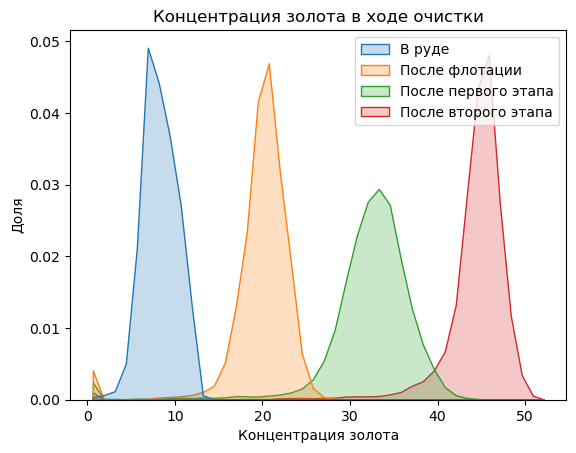

In [244]:
conc_au = pd.DataFrame({'В руде': data_full['rougher.input.feed_au'],
                   'После флотации': data_full['rougher.output.concentrate_au'],
                    'После первого этапа': data_full['primary_cleaner.output.concentrate_au'],
                     'После второго этапа': data_full['final.output.concentrate_au']})
print(conc_au.describe())

fig = sns.histplot(data=conc_au, element="poly", stat='density')
plt.xlabel("Концентрация золота")
plt.ylabel("Доля")
plt.title("Концентрация золота в ходе очистки")
plt.show(fig)

             В руде  После флотации  После первого этапа  После второго этапа
count  19439.000000    19439.000000         19439.000000         19439.000000
mean       8.794927       11.994759             8.442408             5.168387
std        1.936847        2.733862             2.054465             1.372362
min        0.010000        0.000000             0.000000             0.000000
25%        7.237967       10.628337             7.263288             4.251000
50%        8.593574       12.098115             8.507298             5.066039
75%       10.213771       13.736996             9.809001             5.895401
max       14.596026       24.480271            16.081632            16.001945


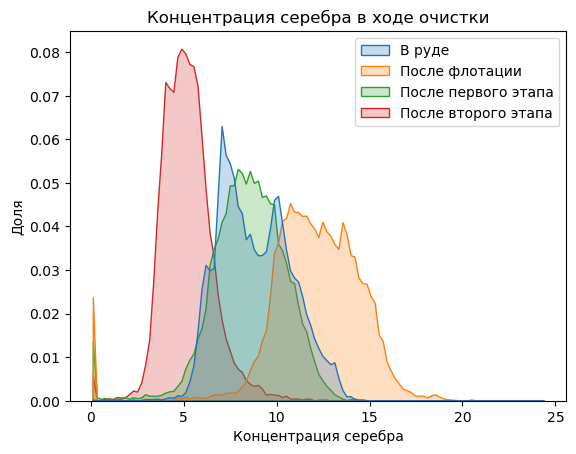

In [245]:
conc_ag = pd.DataFrame({'В руде': data_full['rougher.input.feed_ag'],
                   'После флотации': data_full['rougher.output.concentrate_ag'],
                    'После первого этапа': data_full['primary_cleaner.output.concentrate_ag'],
                     'После второго этапа': data_full['final.output.concentrate_ag']})
print(conc_ag.describe())

fig = sns.histplot(data=conc_ag, element="poly", stat='density')
plt.xlabel("Концентрация серебра")
plt.ylabel("Доля")
plt.title("Концентрация серебра в ходе очистки")
plt.show(fig)

             В руде  После флотации  После первого этапа  После второго этапа
count  19439.000000    19439.000000         19439.000000         19439.000000
mean       3.585096        7.606272             9.810317             9.978821
std        1.062972        1.796757             2.572253             1.669228
min        0.010000        0.000000             0.000000             0.000000
25%        2.872178        6.725987             8.676500             9.137225
50%        3.528235        7.742580            10.142270            10.102264
75%        4.241005        8.565199            11.416298            11.035644
max        7.142594       13.617072            17.081278            17.031899


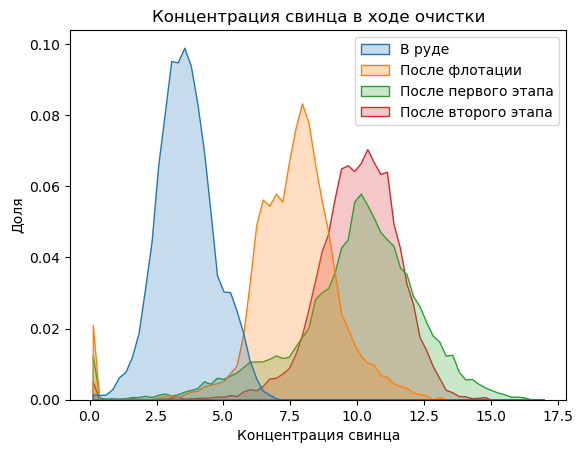

In [246]:
conc_pb = pd.DataFrame({'В руде': data_full['rougher.input.feed_pb'],
                   'После флотации': data_full['rougher.output.concentrate_pb'],
                    'После первого этапа': data_full['primary_cleaner.output.concentrate_pb'],
                     'После второго этапа': data_full['final.output.concentrate_pb']})
print(conc_pb.describe())

fig = sns.histplot(data=conc_pb, element="poly", stat='density')
plt.xlabel("Концентрация свинца")
plt.ylabel("Доля")
plt.title("Концентрация свинца в ходе очистки")
plt.show(fig)

<style>
    .bordered-cell {
        border: 3px solid black;
        padding: 10px;
    }
</style>

<div class="bordered-cell">

**Выводы**

Золото:
- Хорошо очищается в процессе, в на каждом этапе концентрация растет
- После первого этапа разброс значений больше, чем во всех других этапах

Серебро:
- После флотации наибольшая концетрации
- После первого и второго этапа очистки концентрация заметно падает

Свинец:
- Концентрация растет с начала до окончания первого этапа
- После второго этапа средняя концентрация будет неотличима от первого этапа

**ЗАДАЧА 2.2.**
Сравните распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, - оценка модели будет неправильной.

       Размер сырья тренировочная выборка  Размер сырья тестовая выборка
count                        14149.000000                    5290.000000
mean                            60.239856                      55.952754
std                             23.005310                      19.080334
min                              9.659576                       0.046369
25%                             48.966751                      43.906504
50%                             55.269784                      50.846843
75%                             66.007526                      62.451165
max                            484.967466                     392.494040
Т-тест, значение p-value 3.134338776805464e-39


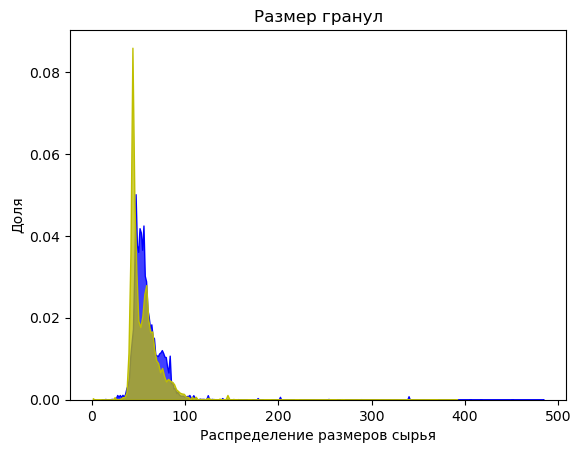

In [247]:
size_df = pd.DataFrame({'Размер сырья тренировочная выборка': data_train['rougher.input.feed_size'],
                   'Размер сырья тестовая выборка': data_test['rougher.input.feed_size']
                       })

print(size_df.describe())

results = st.ttest_ind(data_train['rougher.input.feed_size'],  data_test['rougher.input.feed_size'], equal_var=False)
print ('Т-тест, значение p-value', results.pvalue)

fig = sns.histplot(data=data_train['rougher.input.feed_size'], element="poly", stat='density', color = 'b')
fig = sns.histplot(data=data_test['rougher.input.feed_size'], element="poly", stat='density', color = 'y')
plt.xlabel("Распределение размеров сырья")
plt.ylabel("Доля")
plt.title("Размер гранул")
plt.show(fig)

<style>
    .bordered-cell {
        border: 3px solid black;
        padding: 10px;
    }
</style>

<div class="bordered-cell">

**Вывод**

- Результат т-теста: данные статистически значимо различаются
- Описательная статистика и график: средние значения 60 и 55, стандартное отклонение 23 и 19, графики друг на друга накладываются в целом
- Хотя т-тест говорит о различии, в целом после осмотра буду считать, что выборки размеров гранул похожи

**ЗАДАЧА 2.3.**
Исследуйте суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.

             В руде  После флотации  После первого этапа  После второго этапа
count  19439.000000    19439.000000         19439.000000         19439.000000
mean      57.320789       68.170865            60.764731            68.653624
std        7.212680       12.491279            10.017271             7.427536
min        0.040000        0.000000             0.000000             0.000000
25%       53.557679       66.012495            58.929364            67.932362
50%       57.594391       70.181495            62.497674            69.598444
75%       61.953459       74.356904            65.667336            71.368472
max       76.978947       88.140119            80.749343            80.210644


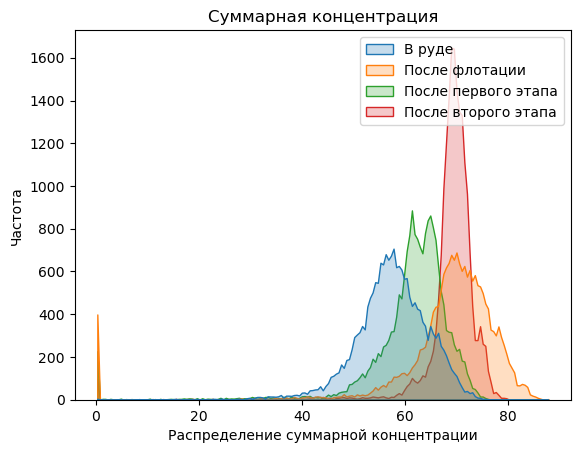

In [248]:
conc_sol = pd.DataFrame({'В руде': data_full['rougher.input.feed_sol'],
                   'После флотации': data_full['rougher.output.concentrate_sol'],
                    'После первого этапа': data_full['primary_cleaner.output.concentrate_sol'],
                     'После второго этапа': data_full['final.output.concentrate_sol']})

# Считаю суммарную концентрацию
conc_sum = conc_pb + conc_au + conc_ag + conc_sol

print(conc_sum.describe())

fig = sns.histplot(data=conc_sum, element="poly")
plt.xlabel("Распределение суммарной концентрации")
plt.ylabel("Частота")
plt.title("Суммарная концентрация")
plt.show(fig)

<style>
    .bordered-cell {
        border: 3px solid black;
        padding: 10px;
    }
</style>

<div class="bordered-cell">

**Вывод**

- С каждым этапом суммарная концетрация растёт
- С каждым этапом разброс значений уменьшается

Удалил наблюдения с концентрацией меньше 1

In [249]:
# Список имен столбцов со значениями концентраций
list_columns_conc = ['rougher.input.feed_au',
                    'rougher.input.feed_ag',
                    'rougher.input.feed_pb',
                    'rougher.input.feed_sol',
                     'rougher.output.concentrate_au',
                     'rougher.output.concentrate_ag',
                     'rougher.output.concentrate_pb',
                     'rougher.output.concentrate_sol',
                     'primary_cleaner.output.concentrate_au',
                     'primary_cleaner.output.concentrate_ag',
                     'primary_cleaner.output.concentrate_pb',
                     'primary_cleaner.output.concentrate_sol',
                    'final.output.concentrate_au',
                    'final.output.concentrate_ag',
                    'final.output.concentrate_pb',
                    'final.output.concentrate_sol',
                    ]

for i in list_columns_conc:
    data_full[i] = data_full[i][data_full[i]>1]
    data_train[i] = data_train[i][data_train[i]>1]

In [250]:
for i in list_columns_conc:
    data_full = data_full[data_full[i]>1]
    data_train = data_train[data_train[i]>1]

# Создание моделей

**ЗАДАЧА 3.1.** Напишите функцию для вычисления итоговой sMAPE.

In [251]:
def smape(target, predictions):
    score = (abs(target - predictions) / (abs(target) + abs(predictions)) * 200).mean()
    smape_total = score['rougher.output.recovery'] * 0.25 + score['final.output.recovery'] * 0.75
    return(round(smape_total, 2))

**ЗАДАЧА 3.2.** Обучите разные модели и оцените их качество кросс-валидацией. Выберите лучшую модель и проверьте её на тестовой выборке. Опишите выводы.

In [252]:
# Список колонок для дальнейшего анализа
list_train_columns = data_test.drop('date', axis=1).columns

(52,)


Готовлю разбивки данных для модели из тренировочных данных

In [253]:
# Удаляю таргет из трейна и создаю таргет
features = data_train.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
features = features[list_train_columns]
target = data_train[['rougher.output.recovery','final.output.recovery']]

Готовлю тестовые данные

In [254]:
# Добавляю к тестовым данным недостающие из исходного датасета
list_columns_merge = list(data_full.columns[~data_full.columns.isin(data_test.columns)])
list_columns_merge.append('date')
data_test_merge = pd.merge(data_test, data_full[list_columns_merge], on="date", how='inner')

Разбиваю тестовые данные на признаки и таргет

In [257]:
# Удаляю таргет из трейна и создаю таргет
features_test = data_test_merge[list_train_columns]
target_test = data_test_merge[['rougher.output.recovery','final.output.recovery']]
#features_test.drop(['rougher.output.recovery','final.output.recovery', 'date'], axis=1, inplace=True)

Делаю одинаковый порядок столбцов

In [258]:
features = features.reindex(sorted(features.columns), axis=1)
target = target.reindex(sorted(target.columns), axis=1)
features_test = features_test.reindex(sorted(features_test.columns), axis=1)
target_test = target_test.reindex(sorted(target_test.columns), axis=1)

Масштабирование данных

In [260]:
# список с именами колонок для фич
features_list_col = features.columns

# Создаю скейлер
scaler = StandardScaler()
# Обучаю скейлер
scaler.fit(features)
# Трансформирую данные
features = scaler.transform(features)
features_test = scaler.transform(features_test)

features_df = pd.DataFrame(data=features, columns=features_list_col)

Строю модель линейной регресии, с проверкой с кросс-валидаецией

In [262]:
smape_scorer = make_scorer(smape)

model = LinearRegression()
model.fit(features, target)

print('Средняя оценка качества модели:', sum(cross_val_score(model, features, target, cv=3, scoring=smape_scorer))/3)

Средняя оценка качества модели: 12.656666666666666


Создаю, обучаю, проверяю модель Support Vector Regression

In [263]:
smape_scorer = make_scorer(smape)

model = MultiOutputRegressor(svm.SVR())

print('Средняя оценка качества модели:', sum(cross_val_score(model, features, target, cv=3, scoring=smape_scorer))/3)

Средняя оценка качества модели: 10.056666666666667


In [264]:
model = DecisionTreeRegressor()
model.fit(features, target)

print('Средняя оценка качества модели:', sum(cross_val_score(model, features, target, cv=3, scoring=smape_scorer))/3)

Средняя оценка качества модели: 14.326666666666668


**Проверка модели SVR на тестовых данных**

In [266]:
best_model = MultiOutputRegressor(svm.SVR())
best_model.fit(features, target)
prediction = best_model.predict(features_test)
score = smape(target_test, prediction)
print(score)

6.95


In [267]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(features, target)
prediction = dummy_regr.predict(features_test)
score = smape(target_test, prediction)
print(score)

7.56


# Результаты

<style>
    .bordered-cell {
        border: 3px solid black;
        padding: 10px;
    }
</style>

<div class="bordered-cell">

**Общий вывод:**
    
- Концентрации металлов в ходе очистки меняются по разному, в зависимости от металла
- Изначальные данные имеют множество проблем, самая основная - необычайно низкие концентрации металлов на различных стадиях. Вероятно это проблемы со сбором данных во время обогащения руды, первое что приходит на ум - некорректно работающие датчики
- В работе были изучены только три модели: линейная регрессия, SVR, решающее дерево. В дальнейшем стоит создать больше различных моделей и сравнить их.
- Лучшей моделью оказался SVR (Epsilon-Support Vector Regression), выбранная метрика sMAPE = 6.95 на тестовых данных
- Если развивать проект дальше, необходимо убрать коллинеарные признаки, и в целом оценить важность признаков. Для этого нужно больше погрузится в процесс обогащения, связаться с техническим отделом, возможно есть еще данные которые можно использовать.